In [1]:
import numpy as np
from numpy import zeros, flip, concatenate, transpose, nan
import math
from math import pi, exp, sqrt
import cmath
from scipy.special import dawsn, erf
from scipy.fft import fft, fftfreq
from scipy.optimize import curve_fit
from statistics import stdev
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error as mse
import random
from inspect import signature
import itertools

In [2]:
def window_coefficient(b=20, max_k=5, Cyc=100, nt=4096):
    """
    Calculate multiplication coefficient (Pk & Qk) of harmonic responses (Vk)
    as a result of the Gaussian windowing function.
    See NLEISView_FFT_Lookup_Table.nb Mathematica file for derivation.
    """
    Pk = zeros((max_k, nt*2))
    Qk = zeros((max_k, nt*2))
    for k_1 in range(max_k):
        k = k_1+1
        ReVpk = zeros(int(nt/2))
        ImVpk = zeros(int(nt/2))
        ReVppk = zeros(int(nt/2))
        ImVppk = zeros(int(nt/2))
        for n in range(int(nt/2)):
            kneg = (b*(-(Cyc*k)+n)*pi)/Cyc
            kpos = (b*(Cyc*k+n)*pi)/Cyc
            cterm = (Cyc-Cyc*nt)/(b*nt)
            ReVpk[n] = b*sqrt(pi)/(4*Cyc) * ( exp(-kneg**2)+exp(-kpos**2) ) * sqrt(2)
            ImVpk[n] = -b/(2*Cyc)*( dawsn(kneg)+dawsn(kpos) ) * sqrt(2)
            ReVppk[n] = b/(2*Cyc)*( dawsn(kneg)-dawsn(kpos) ) * sqrt(2)
            ImVppk[n] = b*sqrt(pi)/(4*Cyc) * ( exp(-kneg**2)-exp(-kpos**2) ) * sqrt(2)
        Pk[k_1,:] = concatenate((flip(ReVpk), ReVpk, flip(ImVpk), ImVpk))
        Qk[k_1,:] = concatenate((flip(ReVppk), ReVppk, flip(ImVppk), ImVppk))
    return Pk, Qk

In [24]:
def baseline_correction(nt=4096):
    """
    Generate baseline coefficients for the FFT linear fitting.
    """
    BC = zeros((4,nt*2))
    BC[0,nt:] = 1
    BC[1,:nt] = 1
    BC[2,:] = list(range(int(nt/2)))+list(range(int(nt/2)-1,-1,-1))+list(range(int(nt/2)))+list(range(int(nt/2)-1,-1,-1))
    BC[3,:] = list(range(int(nt/2)-1,-1,-1))+list(range(int(nt/2)))+list(range(int(nt/2)-1,-1,-1))+list(range(int(nt/2)))
    return BC

In [4]:
def lookup_table(Pk, Qk, BC):
    """
    Combining the multiplication coefficient with the baseline into lookup table.
    """
    m, n = np.shape(Qk)
    LUT = zeros((n, 14))
    for i in range(n):
        LUT[i,0] = Pk[0,i]
        LUT[i,2] = Pk[1,i]
        LUT[i,4] = Pk[2,i]
        LUT[i,6] = Pk[3,i]
        LUT[i,8] = Pk[4,i]
        LUT[i,1] = Qk[0,i]
        LUT[i,3] = Qk[1,i]
        LUT[i,5] = Qk[2,i]
        LUT[i,7] = Qk[3,i]
        LUT[i,9] = Qk[4,i]
        LUT[i,10:] = BC[:,i]
    return LUT

In [5]:
def FFT(y):
    """
    Perform the Fourier transform of the data and realign the FFT results.
    """
    FFT = fft(y, norm = "forward")
    FFT = FFT[:int(len(FFT)/2)]*sqrt(2)
    ReFFT = FFT.real
    ImFFT = FFT.imag
    return concatenate((flip(ReFFT), ReFFT, flip(ImFFT), ImFFT))

In [6]:
def rms(y1, y2, loc, length):
    """
    Calculate root mean squared error between two arrays.
    """
    return mse(y1[loc:loc+length], y2[loc:loc+length], squared=False)

def alpha_noise(FFT, FFT_fit, sigma_x = 3):
    """
    Calculate level of noise in FFT signal.
    """
    loc = 10
    length = 500
    sigma_dif = stdev(FFT[loc:loc+length]-FFT_fit[loc:loc+length])
    return sigma_dif*sigma_x

In [7]:
def one_amp(file_name, LUT, galvano=True, b=20, sigma_x=3, distance_ratio = 3):
    """
    For each raw voltage-current file:
        _ Perform FFT on voltage & current data
        _ Use linear regression between lookup values and FFT response to
            extract the harmonic responses (Vk) in voltage/current for
            galvanostatic/potentiostatic experiment
        _ Eliminate harmonic responses (Vk) if they don't pass signal quality checks.
        _ Return harmonic responses (Vk) and the linear reression fit errors (fit_error).
    """
    # Extract oscillation frequency
    with open(file_name, "r") as file:
        f=float(file.readline().split("\t")[1])
    # Extract voltage current time series:
    data = transpose(np.genfromtxt(file_name, skip_header=1))
    # If exp is galvanostatic: current index is 1, voltage index is 2
    if galvano == False:
        dummy = data
        data[1,:] = dummy[2,:]
        data[2,:] = dummy[1,:]
    # Set t0 = 0:
    data[0,:] = data[0,:]-data[0,0]
    # Subtract DC current/voltage:
    data[1,:] = data[1,:]-np.mean(data[1,:])
    data[2,:] = data[2,:]-np.mean(data[2,:])
    # Apply Gaussian windowing to signal:
    data[1,:] = data[1,:]*np.exp(-np.square(data[0,:]*f/b))
    data[2,:] = data[2,:]*np.exp(-np.square(data[0,:]*f/b))
    # Perform Fourier Transform
    I_FFT = FFT(data[1,:])
    V_FFT = FFT(data[2,:])
    
    # Process the FFT current:
    I_reg = LinearRegression().fit(LUT, I_FFT)
    I_FFT_fit = I_reg.predict(LUT)
    I_coef = I_reg.coef_
    I_baseline = np.sum(I_coef[10:]*LUT[:,10:], axis=1)
    # Process the FFT voltage:
    V_reg = LinearRegression().fit(LUT, V_FFT)
    V_FFT_fit = V_reg.predict(LUT)
    V_coef = V_reg.coef_
    V_baseline = np.sum(V_coef[10:]*LUT[:,10:], axis=1)
    # V1fit = V1' P1 + V1" Q1
    V1p = V_coef[0]
    V1pp = V_coef[1]
    P1 = LUT[:,0]
    Q1 = LUT[:,1]
    V1fit = V1p*P1+V1pp*Q1
    V1fit_plus_baseline = V1fit + V_baseline
    # Voltage signal quality checks:
    # Check whether distance of Vk to baseline is greater than noise level:
    V_alpha_noise = alpha_noise(V_FFT, V_FFT_fit, sigma_x=sigma_x)
    loc_list = [1938, 1838, 1738, 1638, 1538]
    fit_error = zeros(5)
    for i, loc in zip(range(5), loc_list):
        fit_error[i] = rms(V_FFT, V_FFT_fit, loc, 20)
        if i == 0:
            Vk_to_baseline = rms(V_FFT, V_baseline, loc, 20)
        else:
            Vk_to_baseline = rms(V_FFT, V1fit_plus_baseline, loc, 20)
        if Vk_to_baseline/V_alpha_noise < 1.0:
            V_coef[2*i] = nan
            V_coef[2*i+1] = nan
        # Then, check whether (Vk distance to baseline)/(V_FFT fit error) > distance_ratio threshold:
        else:
            if Vk_to_baseline/fit_error[i] < distance_ratio:
                V_coef[2*i] = nan
                V_coef[2*i+1] = nan
    # Correct voltage phase to current's phase:
    I1_Re = I_coef[0]
    I1_Im = I_coef[1]
    alpha, I1_phase = cmath.polar(I1_Re+1j*I1_Im)
    Vk = zeros(10)
    for i in range(5):
        if math.isnan(V_coef[2*i]):
            Vk[2*i] = nan
            Vk[2*i+1] = nan
        else:
            Vi_Re = V_coef[2*i]
            Vi_Im = V_coef[2*i+1]
            Vi_mag, Vi_phase = cmath.polar(Vi_Re+1j*Vi_Im)
            Vi_phase = Vi_phase - I1_phase*(i+1)
            Vi = cmath.rect(Vi_mag, Vi_phase)
            Vk[2*i] = Vi.real
            Vk[2*i+1] = Vi.imag
    return alpha, Vk, fit_error, f

In [8]:
def remove_nan(alpha, Vk_Re, Vk_Im, error):
    """
    Remove nan values before fitting Vk to a power series.
    nan values are from not passing signal quality checks.
    """
    return alpha[~np.isnan(Vk_Re)], Vk_Re[~np.isnan(Vk_Re)], Vk_Im[~np.isnan(Vk_Re)], error[~np.isnan(Vk_Re)]

In [9]:
def select_fit_function(k):
    """
    Each harmonics fit to a different current AC amplitude power series.
        _ alpha: current AC amplitude.
    """
    if k==1:
        foo = foo_V1
    elif k==2:
        foo = foo_V2
    elif k==3:
        foo = foo_V3
    elif k==4:
        foo = foo_V4
    elif k==5:
        foo = foo_V5
    return foo

def foo_V1(alpha, V11, V13, V15):
    return V11*alpha + V13*pow(alpha,3) + V15*pow(alpha,5)

def foo_V2(alpha, V22, V24):
    return V22*pow(alpha,2) + V24*pow(alpha,4)

def foo_V3(alpha, V33, V35):
    return V33*pow(alpha,3) + V35*pow(alpha,5)

def foo_V4(alpha, V44):
    return V44*pow(alpha,4)

def foo_V5(alpha, V55):
    return V55*pow(alpha,5)

In [10]:
def cal_Vkm_fit(alpha, Vk, fit_error):
    """
    Fit Vk to the power series of Vkm.
    """
    Vkm_fit = []
    for i in range(5):
        k=i+1
        Vk_Re = Vk[:,2*i]
        Vk_Im = Vk[:,2*i+1]
        error = fit_error[:,i]
        alpha_cut, Vk_Re, Vk_Im, error = remove_nan(alpha, Vk_Re, Vk_Im, error)
        # if there are enough data points, use the fit function:
        foo = select_fit_function(k)
        no_params = len(signature(foo).parameters)-1
        if len(alpha_cut)>no_params+3:
            Vkm_Re = bootstrap_fit(alpha_cut, Vk_Re, foo, error)
            Vkm_Im = bootstrap_fit(alpha_cut, Vk_Im, foo, error)
            Vkm_fit = Vkm_fit + [list(Vkm_Re), list(Vkm_Im)]
        else:
            Vkm_fit = Vkm_fit + [[nan for i in range(no_params)], [nan for i in range(no_params)]]
    Vkm_fit = list((itertools.chain(*Vkm_fit)))
    return Vkm_fit

In [11]:
def bootstrap_fit(alpha, Vk, foo, error, N=20):
    """
    bootstrapping the power series fit of Vk.
    """
    popt, pcov = curve_fit(foo, alpha, Vk)
    popt_N = zeros((len(popt), N))
    for i in range(N):
        rnd_error = np.array([random.uniform(-2,2)*e for e in error])
        Vk_noise = Vk+rnd_error
        popt, pcov = curve_fit(foo, alpha, Vk_noise)
        popt_N[:,i] = popt
    return popt_N.mean(axis=1)

In [12]:
def one_freq(file_ext, amp_no, LUT):
    """
    For one frequency
        _ extract the harmonic responses (Vk) from each oscillation amplitude (alpha).
        _ fit Vk to power series of alpha to get Vkm.
        _ return a list of the frequency and Vkm values.
    """
    alpha = zeros(amp_no)
    Vk = zeros((amp_no, 10))
    fit_error = zeros((amp_no, 5))
    for i in range(amp_no):
        file_name = file_ext + " " + str(i+1)
        alpha[i], Vk[i,:], fit_error[i,:], f = one_amp(file_name, LUT, sigma_x=3, distance_ratio = 3)
    Vkm = cal_Vkm_fit(alpha, Vk, fit_error)
    return [f]+Vkm

In [13]:
def NLEIS(save_name, file_loc, freq_no, amp_no):
    """
    Perform data analysis from the NLEIS raw voltage-current data and save results into a text file.
        save_name: save location for the NLEIS data analysis results.
        file_loc: where the raw data located, with any prefixes.
        freq_no: number of studied frequency.
        amp_no: number of studied oscillation amplitude (alpha.
    """
    Pk, Qk = window_coefficient(b=20, max_k=5, Cyc=100, nt=4096)
    BC = baseline_correction(nt=4096)
    LUT = lookup_table(Pk, Qk, BC)
    write_data = []+[column_labels()]
    for i in range(freq_no):
        file_ext = file_loc + " " + str(i+1)
        write_data = write_data + [one_freq(file_ext, amp_no, LUT)]
    with open(save_name, "w") as save_file:
        save_file.writelines('\t'.join(str(j) for j in i) + '\n' for i in write_data)
    return

In [14]:
def column_labels():
    """
    NLEIS save file column labels
    """
    V1_coef = ["V11", "V13", "V15"]
    V2_coef = ["V22", "V24"]
    V3_coef = ["V33", "V35"]
    V4_coef = ["V44"]
    V5_coef = ["V55"]
    labels = ["f[Hz]"]
    for coef in [V1_coef, V2_coef, V3_coef, V4_coef, V5_coef]:
        labels = labels + [i+"_Re" for i in coef] + [i+"_Im" for i in coef] 
    return labels


In [5]:
from NLEIS import NLEIS

In [6]:
save_name = "../example/NLEIS_quick.txt"
file_loc ="../example/_NLEISdata/r"
amp_no = 20
freq_no = 41

NLEIS(save_name, file_loc, freq_no, amp_no)

In [5]:
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

In [6]:
df = pd.read_csv(save_name,delimiter="\t")

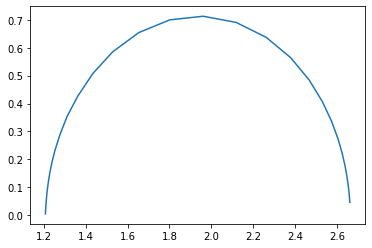

In [7]:
plt.plot(df["V11_Re"], -df["V11_Im"])

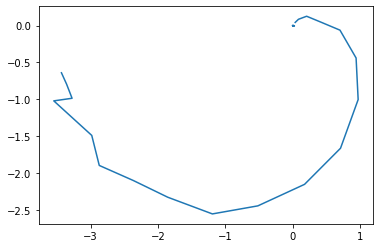

In [8]:
plt.plot(df["V33_Re"], -df["V33_Im"])

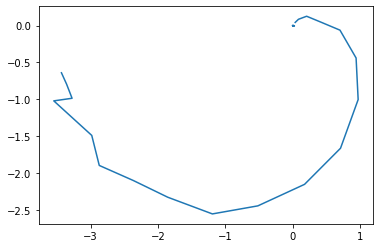

In [8]:
plt.plot(df["V33_Re"], -df["V33_Im"])

In [28]:


# Calculate ratio of alpha noise over alpha fitting error:
I_alpha_fit_error = rms(I_FFT, I_FFT_fit, 1942, 11)
I_alpha_noise = alpha_noise(I_FFT, I_FFT_fit)
I_alpha_noise_to_error = I_alpha_noise/I_alpha_fit_error

# Calculate ratio of alpha peak over alpha noise :
I_alpha_left = rms(I_FFT, I_baseline, 1942, 11)
I_alpha_right = rms(I_FFT, I_baseline, 6037, 11)
I_alpha_peak_to_noise = (I_alpha_left+I_alpha_right)/2/(I_alpha_noise)

In [63]:
# calculate peak to noise ratio:
V_peak_to_noise = zeros(5)
V_noise_to_error = zeros(5)

left_loc = np.array([1942, 1842, 1742, 1642, 1542])
right_loc = left_loc_list + 4095

for i, left, right in zip(range(5), left_loc, right_loc):
    if i == 0:
        V_peak = ( rms(V_FFT, V_baseline, left, 11)+rms(V_FFT, V_baseline, right, 11) )/2
    else:
        V_peak = ( rms(V_FFT, V1fit_plus_baseline, left, 11)+rms(V_FFT, V1fit_plus_baseline, right, 11) )/2
    fit_error = ( rms(V_FFT, V_FFT_fit, left, 11)+rms(V_FFT, V_FFT_fit, right, 11) )/2
    peak_to_noise = V_peak/V_alpha_noise
    noise_to_error = V_alpha_noise/fit_error
    V_peak_to_noise[i] = peak_to_noise
    V_noise_to_error[i] = noise_to_error


In [63]:
[]+[column_labels()]+[column_labels()]

[['f[Hz]',
  'V11_Re',
  'V13_Re',
  'V15_Re',
  'V11_Im',
  'V13_Im',
  'V15_Im',
  'V22_Re',
  'V24_Re',
  'V22_Im',
  'V24_Im',
  'V33_Re',
  'V35_Re',
  'V33_Im',
  'V35_Im',
  'V44_Re',
  'V44_Im',
  'V55_Re',
  'V55_Im'],
 ['f[Hz]',
  'V11_Re',
  'V13_Re',
  'V15_Re',
  'V11_Im',
  'V13_Im',
  'V15_Im',
  'V22_Re',
  'V24_Re',
  'V22_Im',
  'V24_Im',
  'V33_Re',
  'V35_Re',
  'V33_Im',
  'V35_Im',
  'V44_Re',
  'V44_Im',
  'V55_Re',
  'V55_Im']]

In [1]:
from NLEIS import column_labels

In [3]:
column_labels()[1:]

['V11 Re',
 'V13 Re',
 'V15 Re',
 'V11 Im',
 'V13 Im',
 'V15 Im',
 'V22 Re',
 'V24 Re',
 'V22 Im',
 'V24 Im',
 'V33 Re',
 'V35 Re',
 'V33 Im',
 'V35 Im',
 'V44 Re',
 'V44 Im',
 'V55 Re',
 'V55 Im']